In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
retail = pd.read_excel("Online Retail.xlsx")
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail_df = round(100*(retail.isnull().sum())/len(retail),2)
retail_df

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [6]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [7]:
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
MRF_m = retail.groupby('CustomerID')['Amount'].sum().reset_index()
MRF_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [8]:
MRF_f = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
MRF_f.columns = ['CustomerID','Frequency']
MRF_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [9]:
MRF = pd.merge(MRF_m, MRF_f, on = 'CustomerID', how = 'inner')
MRF.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [10]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = '%d-%m-%Y %H:%M')

In [11]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [12]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [13]:
MRF_p = retail.groupby('CustomerID')['Diff'].min().reset_index()
MRF_p

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [14]:
MRF_p['Diff'] = MRF_p['Diff'].dt.days
MRF_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [15]:
MRF = pd.merge(MRF, MRF_p, on = 'CustomerID', how = 'inner')
MRF.columns = ['CustomerID','Amount','Frequency','Recency']
MRF.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

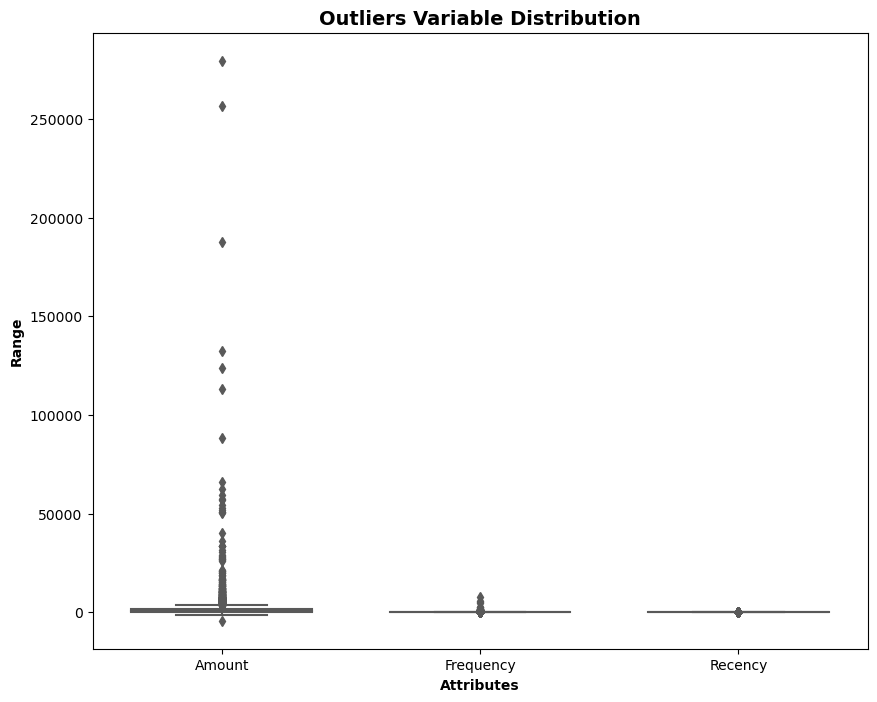

In [16]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = MRF[attributes], orient = "v", palette = "Set2", whis = 1.5, saturation = 1, width = 0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [17]:
Q1 = MRF.Amount.quantile(0.05)
Q3 = MRF.Amount.quantile(0.95)
IQR = Q3 - Q1
MRF = MRF[(MRF.Amount >= Q1 - 1.5 * IQR) & (MRF.Amount <= Q3 + 1.5 * IQR)]

Q1 = MRF.Frequency.quantile(0.05)
Q3 = MRF.Frequency.quantile(0.95)
IQR = Q3 - Q1
MRF = MRF[(MRF.Frequency >= Q1 - 1.5 * IQR) & (MRF.Frequency <= Q3 + 1.5 * IQR)]

Q1 = MRF.Recency.quantile(0.05)
Q3 = MRF.Recency.quantile(0.95)
IQR = Q3 - Q1
MRF = MRF[(MRF.Recency >= Q1 - 1.5 * IQR) & (MRF.Recency <= Q3 + 1.5 * IQR)]

In [18]:
MRF_df = MRF[['CustomerID','Amount','Frequency','Recency']]
scaler = StandardScaler()
MRF_df_scaled = scaler.fit_transform(MRF_df)
print(MRF_df.head())
print(f"Number of rows in MRF_df: {len(MRF_df)}")

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309
Number of rows in MRF_df: 4293


In [20]:
MRF_df_scaled = pd.DataFrame(MRF_df_scaled)
MRF_df_scaled.columns = ['CustomerID','Amount','Frequency','Recency']
MRF_df_scaled.head()

,CustomerID,Amount,Frequency,Recency
0,-1.714651,-0.723738,-0.752888,2.301611
1,-1.714070,1.731617,1.042467,-0.906466
2,-1.713490,0.300128,-0.463636,-0.183658
3,-1.712909,0.277517,-0.044720,-0.738141
4,-1.712329,-0.533235,-0.603275,2.143188


In [21]:
kmeans =KMeans(n_clusters = 4, max_iter = 50)
kmeans.fit(MRF_df_scaled)

KMeans(max_iter=50, n_clusters=4)

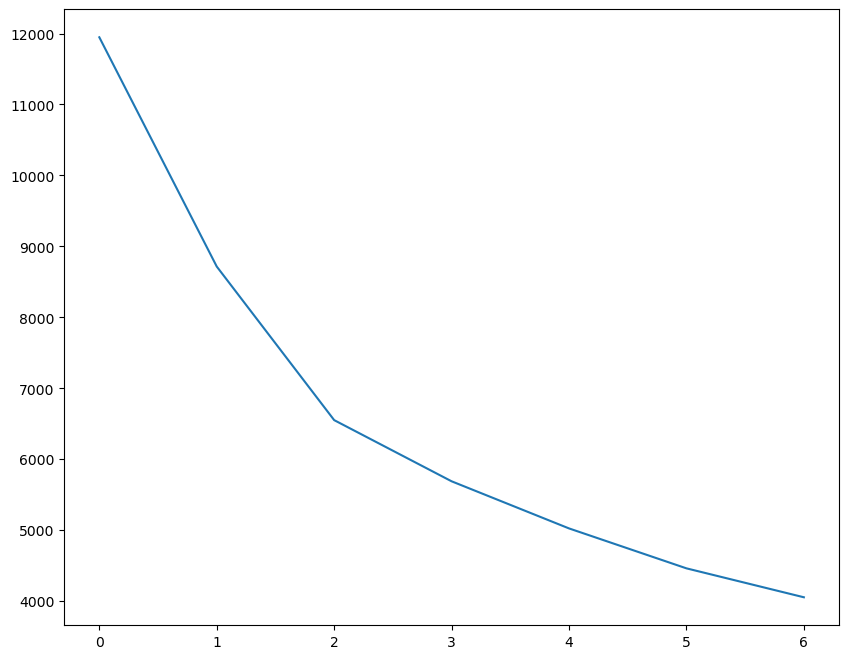

In [22]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(MRF_df_scaled)
    
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

In [23]:
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(MRF_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(MRF_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is{1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is0.4305363247046046
For n_clusters=3, the silhouette score is0.34324453429687557
For n_clusters=4, the silhouette score is0.3420293287724527
For n_clusters=5, the silhouette score is0.33866717359721127
For n_clusters=6, the silhouette score is0.3336386465554719
For n_clusters=7, the silhouette score is0.33589512868944327
For n_clusters=8, the silhouette score is0.3255659603542759


In [24]:
kmeans =KMeans(n_clusters = 3, max_iter = 50)
kmeans.fit(MRF_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [25]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [26]:
MRF['ClusterID'] = kmeans.labels_
MRF.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


<Axes: xlabel='ClusterID', ylabel='Amount'>

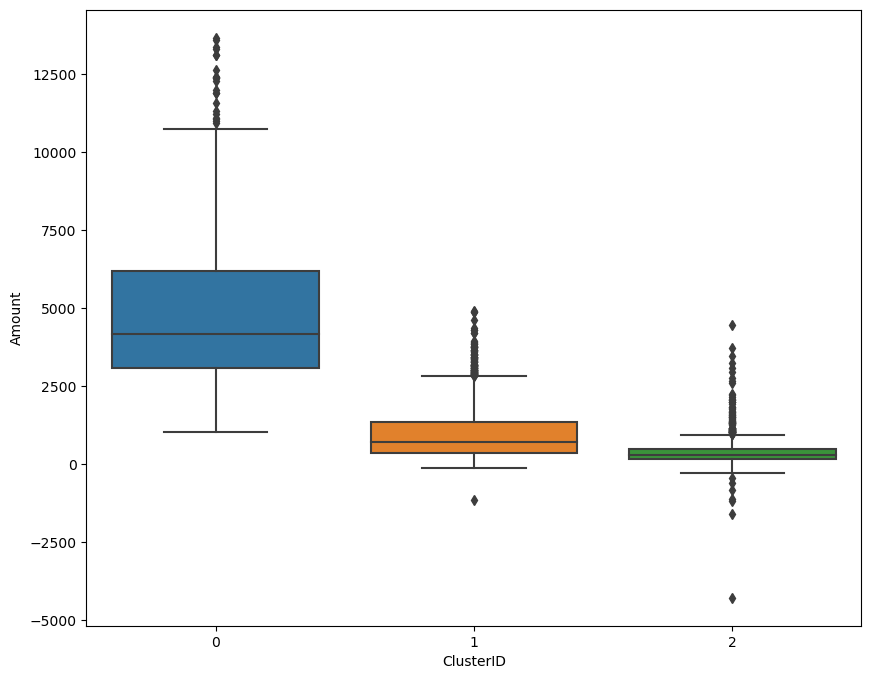

In [27]:
sns.boxplot(x = 'ClusterID', y = 'Amount', data = MRF)

<Axes: xlabel='ClusterID', ylabel='Frequency'>

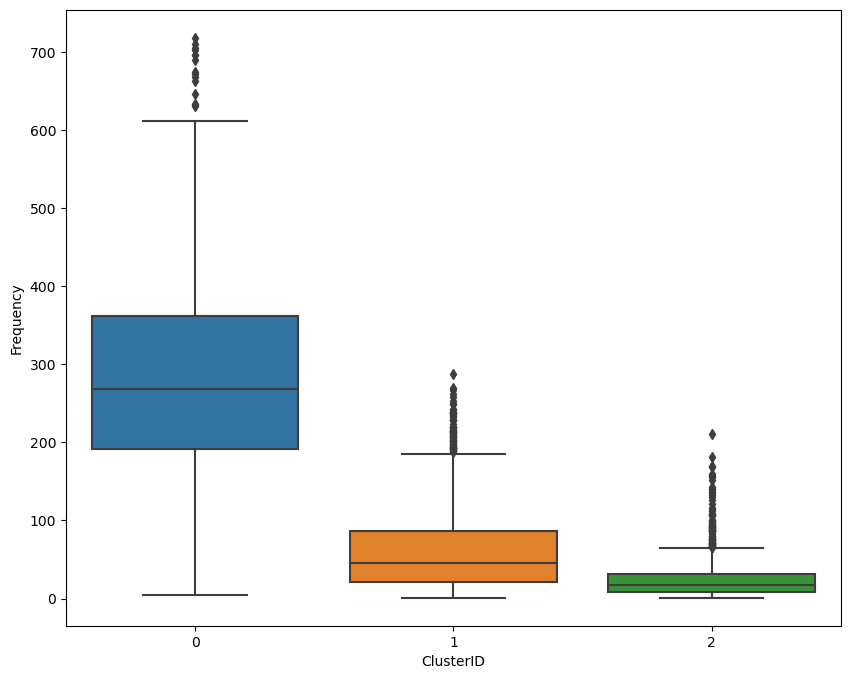

In [28]:
sns.boxplot(x = 'ClusterID', y = 'Frequency', data = MRF)

<Axes: xlabel='ClusterID', ylabel='Recency'>

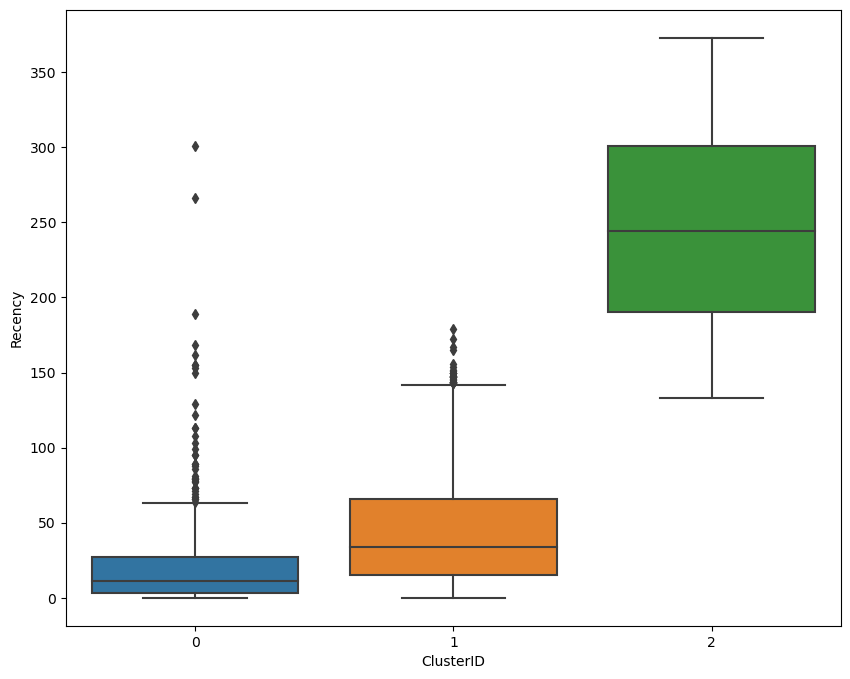

In [29]:
sns.boxplot(x = 'ClusterID', y = 'Recency', data = MRF)

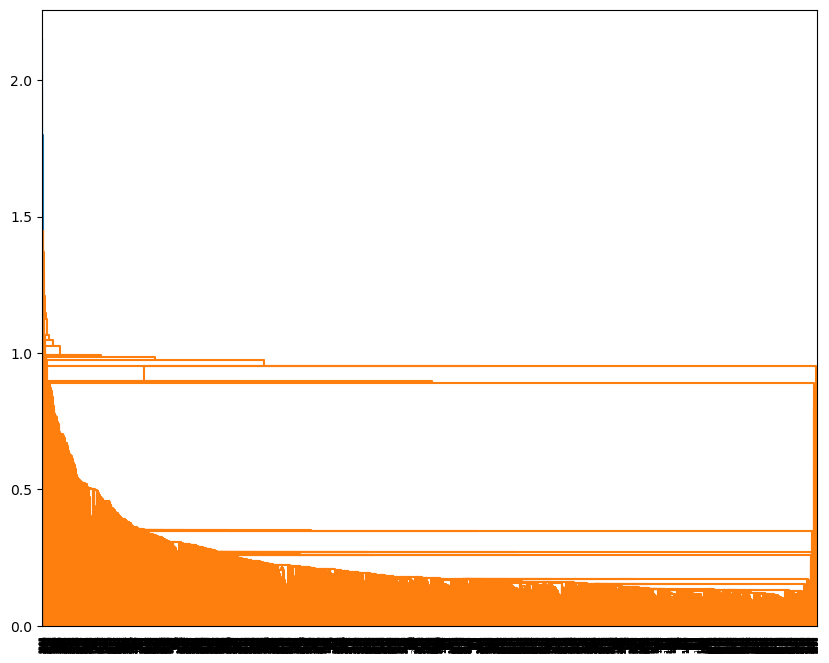

In [30]:
mergings = linkage(MRF_df_scaled, method = "single", metric = 'euclidean')
dendrogram(mergings)
plt.show()

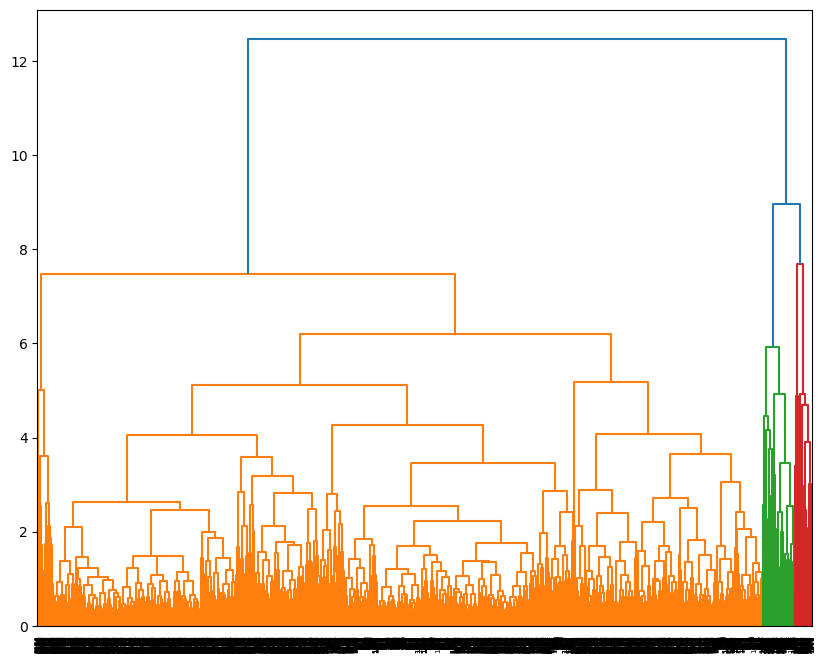

In [31]:
mergings = linkage(MRF_df_scaled, method = "complete", metric = 'euclidean')
dendrogram(mergings)
plt.show()

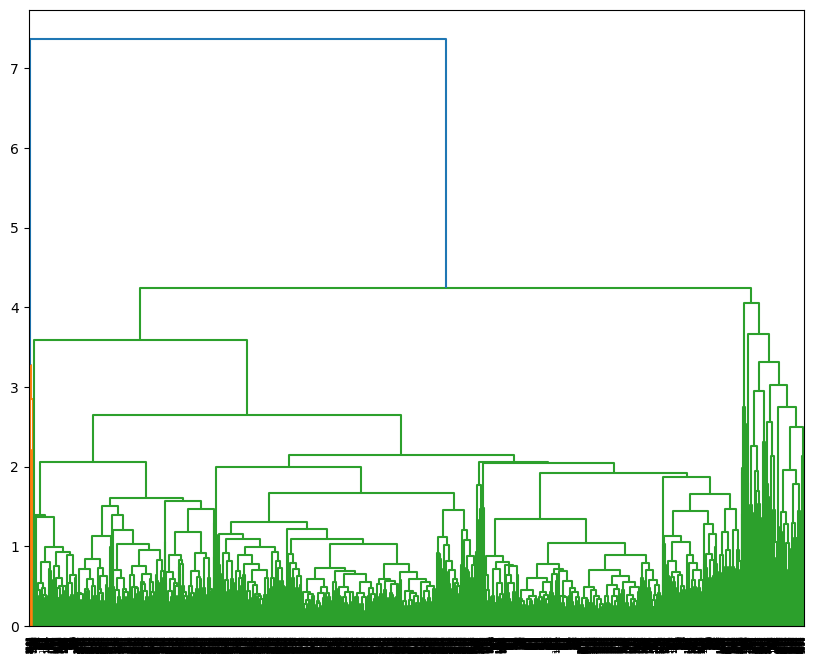

In [32]:
mergings = linkage(MRF_df_scaled, method = "average", metric = 'euclidean')
dendrogram(mergings)
plt.show()

In [34]:
cluster_labels = cut_tree(mergings, n_clusters = 3).reshape(-1,)
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
MRF['Cluster_labels'] = cluster_labels
MRF.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,cluster_labels,Cluster_labels
0,12346.0,0.00,2,325,2,0,0
1,12347.0,4310.00,182,1,0,0,0
2,12348.0,1797.24,31,74,1,0,0
3,12349.0,1757.55,73,18,1,0,0
4,12350.0,334.40,17,309,2,0,0


<Axes: xlabel='Cluster_labels', ylabel='Amount'>

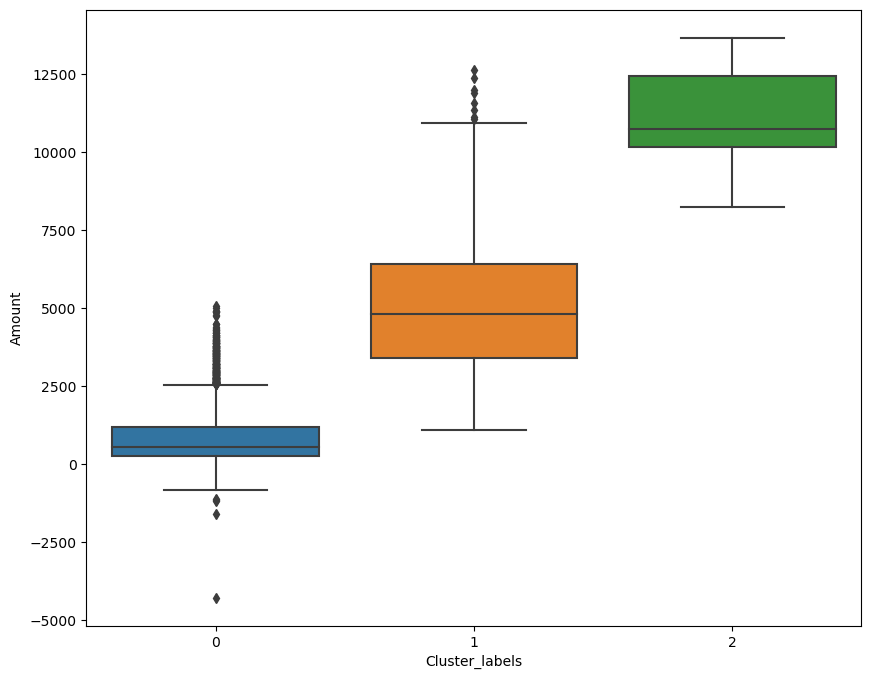

In [41]:
sns.boxplot(x = 'Cluster_labels', y = 'Amount', data = MRF)

<Axes: xlabel='Cluster_labels', ylabel='Frequency'>

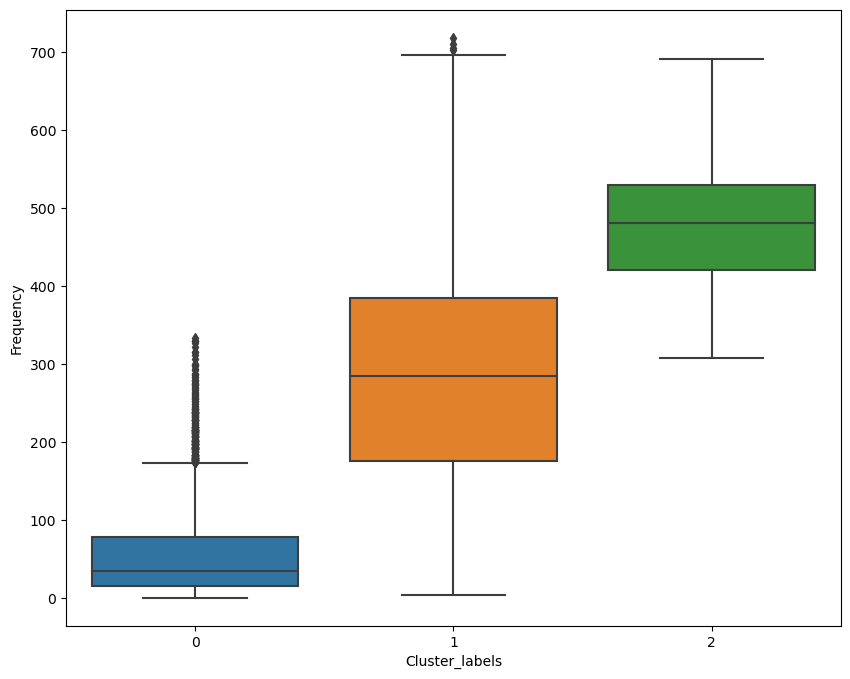

In [42]:
sns.boxplot(x = 'Cluster_labels', y = 'Frequency', data = MRF)

<Axes: xlabel='Cluster_labels', ylabel='Recency'>

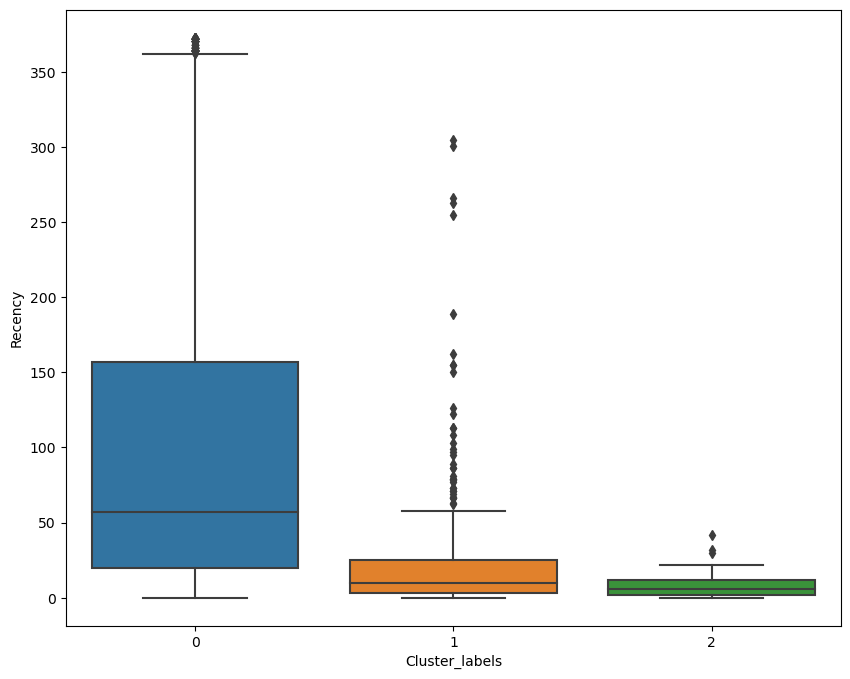

In [43]:
sns.boxplot(x = 'Cluster_labels', y = 'Recency', data = MRF)